#  Natural Language Processing (NLP) -  Working Copy

### Improving online conversation: Use of NLP analysis to build a multi-headed model capable of detecting different types of online discussion toxicity like threats, obscenity, insults, and identity-based hate.

 * Blog post URL: https://andiosika.github.io/focal_loss_in_deep_learning

>**WARNING:** The nature of this project comes with extremly offensive language.  The intention is to use analysis in order to mitigate situations where others feel unable to share their views at the risk of abuse or feeling that are in harm's way.  Please note that the language comes from an external source and does not represent personal language usage.

## Project Quick Links:
**Link** | **Description**
--| --|
[Background](#Background:) | Details around the subject, datasource and objective
[Preprocessing](#Preprocessing:) | Steps taken to prepare data for modeling and evaluation
[Visualizations](Visualizations:) |[Types of Toxicity by Occurance](#Visual:-Types-of-Toxic-Comments-by-Occurence:) , [Correlations Between Classes](#Visual:-Correlations-between-varying-forms-of-toxicity:) and others.
[Main Dataset](#Main-Dataset:) | The dataset in it's final form used for the predictive modeling results described in the [Conclusion](#Conclusion:) section which splits ~150K samples into a [Train_Test_Split](#Train-Test-Split:) with 6 multi-label categories of in some cases extremely imbalanced sampling of targets.
[Modeling](#Modeling:) | Various iterations of Neural Netorks including Recurrent Neural Networks using LSTM and BinomalFocal Loss - 
[Best Model](#Best-Model:-LSTM_50_Dense_25_Binary_Focal_Loss) | A Recurrent Neural Netork using Long Short Term Meory and Binomal Focal loss. 
[Conclusion](#Conclusion:) | Summation of outcomes from modeling
[Recommendations](#Recommendations:)| Recommendations from findings as well as ideas for future work.

In [1]:

#<img src='https://raw.githubusercontent.com/andiosika/dsc-mod-4-project-v2-1-online-ds-pt-100719/images/CleanWrdCloud'width=40%alignment=l>

## Background:

Freedom of speech is a right.  Digital platforms facilitate conversations, but struggle to do so efficiently.  While enabling this freedom, minimizing abuse and harrasment that can come with the 'anonymity effect' of a virtual climate can be challenging.  Those who feel threatened or abused could potentially not share their thoughts when considering the reprecussions thereby defeating the purpose of sharing altogether.  While freedom of speech exists, the law has long recognized specific limitations when it comes to to this freedom - such as prohibitions against slander and libel.  Detection of such language becomes valuable for providers in order to keep the conversation going in a way that is constructive in order for users to use such platforms in the way they were intended. 

This dataset is provided by [Conversation AI ](https://conversationai.github.io/) is a collaborative research effort exploring ML as a tool for better discussions online.  The source is a collection of comments from Wikipedia’s talk page edits circa 2017.  The result is a classification list of 159,571 samples provided by Wikipedia and have been labeled by human raters for toxic effects.  These comment classifications can fall into more than one of the following categories:

>The types of toxicity are:
* toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate


**Warning:** the text found in each of the categories outlined above is extremely offensive.  The supporting visualizations are equally offensive.  Because of this, edited versions of some the most offensive findings were/are edited text that I feel conveys the ideas without perpetuating the toxic messages and used for the non-technical explanation.  However the findings in this analysis are necessary for identification's sake.  The intention is to use this type of analysis in order to mitigate situations where others feel unable to share their views at the risk of abuse or feeling that are in harm's way.

In [4]:
from numpy.random import seed
seed(1)

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

## Preprocessing:

### Data Import: Trainging and Testing DataSets

#### Test - DID NOT USE THE TESTING DATASET PROVIDED.. INSTEAD SPLIT THE TRAINING DATA TO MAKE THE OVERALL DATASET SMALLER DUE TO THE COMPUTATIONAL EXPENSE CAUSED BY LARGER DATASETS

In [5]:
test = pd.read_csv('test.csv.zip', index_col='id')
test.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
X_test = test['comment_text']

In [7]:
y_test = pd.read_csv('test_labels.csv.zip', index_col='id')


In [8]:
y_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,-1,-1,-1,-1,-1,-1
0000247867823ef7,-1,-1,-1,-1,-1,-1
00013b17ad220c46,-1,-1,-1,-1,-1,-1
00017563c3f7919a,-1,-1,-1,-1,-1,-1
00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [9]:
y_test = y_test[y_test.sum(axis=1)!=-6]
y_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
0001ea8717f6de06,0,0,0,0,0,0
000247e83dcc1211,0,0,0,0,0,0
0002f87b16116a7f,0,0,0,0,0,0
0003e1cccfd5a40a,0,0,0,0,0,0
00059ace3e3e9a53,0,0,0,0,0,0


In [10]:
val_counts_test = y_test.apply(pd.Series.value_counts)
val_counts_test

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,57888,63611,60287,63767,60551,63266
1,6090,367,3691,211,3427,712


<AxesSubplot:>

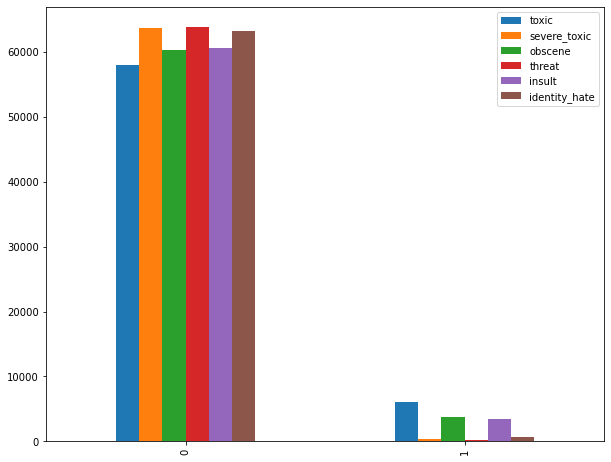

In [11]:
val_counts_test.head(2).plot(kind='bar',figsize=(10,8))

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/55975

#### Main Dataset:

In [12]:
train = pd.read_csv('train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [13]:
X = train['comment_text']

In [14]:
target_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[target_classes]

### Train Test Split:

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8)

In [17]:
val_counts = y_train.apply(pd.Series.value_counts)
val_counts

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,108224,118490,113300,119312,113750,118621
1,11454,1188,6378,366,5928,1057


In [18]:
y_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,119678.000000,119678.000000,119678.000000,119678.000000,119678.000000,119678.000000
mean,0.095707,0.009927,0.053293,0.003058,0.049533,0.008832
std,0.294190,0.099137,0.224618,0.055217,0.216979,0.093563
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
# check for any 'null' comment
no_comment = X_train.isnull().value_counts()
len(no_comment)

1

<AxesSubplot:>

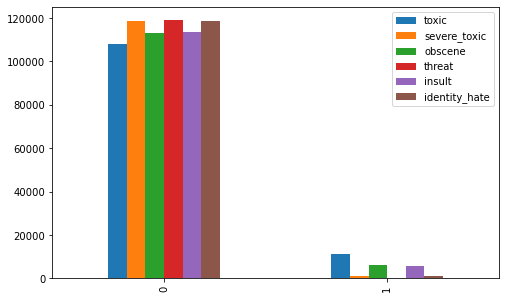

In [20]:
val_counts = y_train.apply(pd.Series.value_counts)
val_counts.head(2).plot(kind='bar',figsize=(8,5))

In [21]:
##develop the viz above to illustrate

In [22]:
value_counts_train = round(val_counts.head(2).T)
value_counts_train

,0,1
toxic,108224,11454
severe_toxic,118490,1188
obscene,113300,6378
threat,119312,366
insult,113750,5928
identity_hate,118621,1057


In [23]:
unlabelled_in_all = y_train[(y_train['toxic']!=1) & (y_train['severe_toxic']!=1) & (y_train['obscene']!=1) & 
                            (y_train['threat']!=1) & (y_train['insult']!=1) & (y_train['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', round(len(unlabelled_in_all)/len(train)*100))

Percentage of unlabelled comments is  67


In [24]:
#Total rows in train
print('Total rows in X_train is {}'.format(len(X_train)))

Total rows in X_train is 119678


In [25]:
toxic_classes = y_train[y_train[target_classes].sum(axis=1)>0]


In [26]:
toxic_classes

,toxic,severe_toxic,obscene,threat,insult,identity_hate
52481,1,0,0,0,0,0
20943,1,0,1,0,1,0
5874,1,0,0,0,1,0
145315,1,0,1,0,1,0
147450,1,0,1,0,0,0
...,...,...,...,...,...,...
35349,1,1,1,0,1,0
53658,1,0,0,0,0,0
22968,1,0,0,0,0,0
142866,1,0,1,0,1,1


You can see here that some labels can be assigned to more than one class

In [27]:
toxic_classes['toxic'].sum()/len(toxic_classes)

0.9429488762657446

.... but not all comments tagged are necessarily 'toxic', but most of them are... 94%

#### Frequency Distributions:

An initial look will examine frequency distributions

In [28]:
# Get all the stop words in the English language
stopwords_list = stopwords.words('english')

# It is generally a good idea to also remove punctuation

# Now we have a list that includes all english stopwords, as well as all punctuation
stopwords_list += list(string.punctuation)

In [29]:
text = str(list(X_train))

### Tokenizing initial set of text corpus to develop stopword list:
(Takes 2 Min)

In [30]:
import functions as fn

2022-04-10 04:07:57.788375+03:00
[i] Timer started at04/10/22 - 04:07 AM
[i] Timer ended at 04/10/22 - 04:07 AM
- Total time = 0:00:00.000023


In [ ]:
timer = fn.Timer()

timer.start()
tokens = word_tokenize(text)
timer.stop()

[i] Timer started at04/10/22 - 04:07 AM


In [ ]:
# Get all the stop words in the English language
stopwords_list = stopwords.words('english')

#remove punctuation
stopwords_list += list(string.punctuation)
##adding adhoc all strings that don't appear to contribute, added 'article, page and wikipedia' iteratively as 
##these are parts of most comment strings
stopwords_list += ("''","``", "'s", "\\n\\n" , '...', 'i\\','\\n',
                   '•', "i", 'the', "'m", 'i\\', "'ve", "don\\'t",
                  "'re", "\\n\\ni", "it\\", "'ll", 'you\\', "'d", "n't",
                  '’', 'article', 'page', 'wikipedia') 

In [ ]:
timer = fn.Timer()
timer.start()
stopped_tokens = [w.lower() for w in tokens if w.lower() not in stopwords_list]
timer.stop()

In [ ]:
len(stopped_tokens)

In [ ]:
from nltk.stem import WordNetLemmatizer 
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
lemmatized_output =[lemmatizer.lemmatize(w) for w in stopped_tokens]

In [ ]:
len(lemmatized_output)

In [ ]:
from nltk import FreqDist
freqdist = FreqDist(stopped_tokens)
most_common_stopped = freqdist.most_common(200)
most_common_stopped

In [ ]:
feq_vals = freqdist.values

In [ ]:
print(feq_vals)

In [ ]:
freqdistlem = FreqDist(lemmatized_output)
most_common_lem = freqdistlem.most_common(200)

In [ ]:
most_common_lem

Lemmatizing gave not much of a  different result

In [ ]:
X_train.head()

## Visualizations: 

### EDA: Looking Deeper at the classes:

In [ ]:
train.head()

In [ ]:
# Creating a copy of the training set to explore/manipulate.

df = train.copy()

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
x=df.iloc[:,2:].sum()
display(x)

In [ ]:
import matplotlib.pyplot as plt

### Visual: Types of Toxic Comments by Occurence:

In [ ]:

x.plot(kind='bar', figsize=(8,5))
plt.xticks(rotation=45)
plt.title('Types of Toxic Comments by Occurence',fontsize=18 )
plt.ylabel('Frequncy of Tag', fontsize=14)
plt.xlabel('Category of Toxic Text', fontsize=14)

Toxic is by far the highest occurance, and threats are significantly lower.

### Examples of Varrying Toxic Text and The Correlations:

***Warning - offensive language** this was text that was imported from the dataset and has not been modified.  As a reminder the point of this excercise is to identify types of toxic language so it is necessary to see samples of each to look for patterns.

In [ ]:
!pip install simple_colors

In [ ]:
 from simple_colors import *

In [ ]:
print(blue("Example of toxic text:",['bold']))
print(train[train['toxic']==1].iloc[2,1])
print('-----------------------------')
print(blue("Example of severe toxic text:",['bold']))
print(train[train['severe_toxic']==1].iloc[3,1])
print('-----------------------------')
print(blue("Example of obscene text:",['bold']))
print(train[train['obscene']==1].iloc[4,1])
print('-----------------------------')
print(blue("Example of threatening text:",['bold']))
print(train[train['threat']==1].iloc[2,1])
print('-----------------------------')
print(blue("Example of insulting text:",['bold']))
print(train[train['insult']==1].iloc[3,1])
print('-----------------------------')
print(blue("Example of identity hate based text:",['bold']))
print(train[train['identity_hate']==1].iloc[39,1])

In [ ]:
import seaborn as sns

### Visual: Correlations between varying forms of toxicity:

In [ ]:
corr=y_train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="Blues", mask=mask, vmin=0, vmax=.95,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)
plt.title('Correlations Between Varying Levels of Toxicity', fontsize=(16))
plt.xlabel('Type of Toxicity (for comparison on y-axis)',fontsize=(12), color='darkblue')
plt.ylabel('Type of Toxicity (for comparison on x-axis)',fontsize=(12), color='darkblue')

In [ ]:
#getting the totals from each row to identify if they had any toxic comments or not
rowtotals = train.iloc[:,2:].sum(axis=1)
df['clean_text'] = (rowtotals==0)
df['toxic_text'] = (rowtotals!=0)

In [ ]:
print("Number of clean comments:", df['clean_text'].sum())
print("Number of toxic comments:", df['toxic_text'].sum())
print("Percentage of toxic comments in sample", (df['toxic_text'].sum()/
                                                      (df['clean_text'].sum() +
                                                       df['toxic_text'].sum()))*100)

In [ ]:
df['wrd_count'] = df['comment_text'].str.count(' ') + 1


### Visual: Toxic Comment Frequency

In [ ]:
df['toxic_text'].value_counts().plot(kind='bar')
plt.title('Toxic Comment Frequency',fontsize=16)
plt.ylabel('Frequency')
plt.xlabel("Toxic Comments", fontsize=12)

In [ ]:
tox_text_df = df.loc[df['toxic_text']==1]
clean_text_df = df.loc[df['clean_text']==1]


Looking to see if ID has some sort of meaning... e.g. user id each value is unique

In [ ]:
sorted(tox_text_df['id'].value_counts(), reverse=True)

In [ ]:
#separate the strings to set up for counting unique numbers:
tox_unique = set()
tox_text_df['text'] = tox_text_df['comment_text'].str.lower().str.split().apply(tox_unique.update)
clean_unique = set()
clean_text_df['text'] = clean_text_df['comment_text'].str.lower().str.split().apply(clean_unique.update)

In [ ]:
print(f'Number of unique words in toxic corpus',len(tox_unique))
print(f'Number of unique words in clean corpus', len(clean_unique))

Since there are far less toxic words, it makes sense there are fewer unique words in the toxic corpus.

In [ ]:
df.iloc[6]

### Visual: Word Count Comparison Toxic vs NonToxic:

In [ ]:
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(tox_text_df['wrd_count'], color='yellow', label='Toxic Text')
sns.distplot(clean_text_df['wrd_count'],color='lightgreen', label='Clean Text')
plt.title('Word Count Comparison', fontsize = 18)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Word Count', fontsize=14)
plt.legend(fontsize=14)

Observation: at a high level, there's not much difference comparatively in terms of word count between toxic and non toxic comments:

In [ ]:
df.head(2)1111111

In [ ]:
# creating separate dataframes for each type of toxicity for possible analysis
ToxicDf = df[(df['toxic'] == 1)]
SevTox = df[(df['severe_toxic'] == 1)]
Obs = df[(df['obscene'] == 1)]
Threat = df[(df['threat'] == 1)]
Inst = df[(df['insult'] == 1)]
IDH8 = df[(df['identity_hate']==1)]        

In [ ]:
#since toxic was highly correlated with obscene, looking into frequency:
tox_obs = df[(df['toxic'] ==1) & (df['obscene'])]
len(tox_obs)

In [ ]:
print("Comments tagged as toxic:", (len(ToxicDf)))
print("Comments tagged as obscene:", (len(Obs)))
print("Comments tagged as toxic and obscene", len(tox_obs))
print("Percentage of comments tagged as toxic and obscene" )
print("compared to soley toxic", (round(len(tox_obs)/len(Obs),2)*100))

In [ ]:
#Text specficially classified for each class
toxic_text = str(list(ToxicDf['comment_text']))
sev_toxic_text = str(list(SevTox['comment_text']))
obs_text = str(list(Obs['comment_text']))
threat_text = str(list(Threat['comment_text']))
insult_text = str(list(Inst['comment_text']))
idh8_text = str(list(IDH8['comment_text']))


In [ ]:
type(threat_text)

In [ ]:
from importlib import reload

In [ ]:
reload(fn)

### Varying Classes of Toxic Text:

Warning: the hidden cells contain extremely toxic text that was collected in the samples.



##### Toxic:

In [ ]:
tox_toks = fn.tok_text(toxic_text)

In [ ]:
type(tox_toks)

In [ ]:
freq_tox = fn.freq_dist(tox_toks)
dict(freq_tox)

In [ ]:
reload(fn)
    
    

In [ ]:
freq_tox_list = fn.clean_up(freq_tox)

In [ ]:
freq_toxic_df = pd.DataFrame(freq_tox_list, columns=['word', 'frequency'])
freq_tox_top_5 = freq_toxic_df[0:4]
freq_tox_top_5

freq_tox_top_5.plot(kind='barh',x='word', y='frequency')
plt.title('Top 5 Toxic Words', fontsize=14)
plt.xlabel('frequency')

##### Common toxic word cloud is extrememly offensive - measures were taken to edit for the sake of observing without perpetuating

In [ ]:
#wordcloud.generate_from_frequencies(',')

In [ ]:
#creating a dictionary of primary offensive words to clean up a visual.  These are highly offensive and
#I am completely uncomfortable even typing them for this purpose, but needs to be done.  Also symbols don't 
#render in a word cloud
dic = {'fuck': 'fword', 'nigger' : "nword" , 'nigga':'nwordderivatie','fucking' : 'fwordderivative',
               'faggot':'offensivewordforgayman', 'cunt' : 'cword' ,'cunts' : 'cwords', 'shit': 'shword', 'fag' : 'offensivewordforgayman',
               "'fuck" : "'fword'", 'faggots':'fwordforgaymen'}

In [ ]:
clean_tox_toks = fn.replace_all(tox_toks, dic )


**Due to the nature and severity of the language, one word cloud will be used to demonstrate common words in the toxic classification:**

In [ ]:
!pip install wordcloud
fn.wrd_cld(clean_tox_toks)


##### Severe Toxic

In [ ]:
sev_tox_toks = fn.tok_text(sev_toxic_text)

In [ ]:
freq_sev_tox = fn.freq_dist(sev_tox_toks)
freq_sev_tox

In [ ]:
freq_sevtox_list = fn.clean_up(freq_sev_tox)

In [ ]:
freq_sevtoxic_df = pd.DataFrame(freq_sevtox_list, columns=['word', 'frequency'])
freq_sevtox_top_5 = freq_sevtoxic_df[0:4]
freq_sevtox_top_5

In [ ]:
freq_sevtox_top_5.plot(kind='barh',x='word', y='frequency')
plt.title('Top 5 Severely Toxic Words', fontsize=14)
plt.xlabel('frequency')

##### Obscene

In [ ]:
obs_toks = fn.tok_text(obs_text)

In [ ]:
obs_tox = fn.freq_dist(obs_toks)

In [ ]:
obs_tox_list = fn.clean_up(obs_tox)

In [ ]:
freq_obs_df = pd.DataFrame(obs_tox_list, columns=['word', 'frequency'])
freq_obs_top_5 = freq_obs_df[0:4]
freq_obs_top_5.plot(kind='barh',x='word', y='frequency')
plt.title('Top 5 Obscene Words', fontsize=14)
plt.xlabel('frequency')

##### Threat

In [ ]:
threat_toks = fn.tok_text(threat_text)

In [ ]:
threat_tox = fn.freq_dist(threat_toks)

In [ ]:
freq_threat_list = fn.clean_up(threat_tox)

In [ ]:
freq_threat_df = pd.DataFrame(freq_threat_list, columns=['word', 'frequency'])
freq_threat_top_5 = freq_threat_df[0:4]
freq_threat_top_5.plot(kind='barh',x='word', y='frequency')
plt.title('Top 5 Threatening Words', fontsize=14)
plt.xlabel('frequency')

###### Insult

In [ ]:

inslt_toks = tok_text(insult_text)

In [ ]:
inslt_tox = freq_dist(inslt_toks)

In [ ]:
inslt_tox_list = clean_up(inslt_tox)

In [ ]:
freq_insult_df = pd.DataFrame(inslt_tox_list, columns=['word', 'frequency'])
freq_insult_top_5 = freq_insult_df[0:4]
freq_insult_top_5.plot(kind='barh',x='word', y='frequency')
plt.title('Top 5 Insulting Words', fontsize=14)
plt.xlabel('frequency')

##### Identity_hate

In [ ]:
idh8_toks = fn.tok_text(idh8_text)

In [ ]:
idh8_tox = fn.freq_dist(idh8_toks)
idh8_tox

In [ ]:
freq_idh8_list = fn.clean_up(idh8_tox)

In [ ]:
freq_idh8_df = pd.DataFrame(freq_idh8_list, columns=['word', 'frequency'])
freq_idh8_top_5 = freq_idh8_df[0:4]
freq_idh8_top_5.plot(kind='barh',x='word', y='frequency')
plt.title('Top 5 Identity-Hate Based Words', fontsize=14)
plt.xlabel('frequency')

## Modeling:

### Tokenizing

In [ ]:
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
#https://github.com/learn-co-students/dsc-classification-with-word-embeddings-codealong-online-ds-pt-100719
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [ ]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
#try texts_to_matrix
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
comments = [len(comment) for comment in list_tokenized_train]

In [ ]:
plt.hist(comments,bins = np.arange(0,500,10))
plt.axvline(x=400, color='g', ls=':')
plt.title('Comment Length of Tokenized Data')
plt.xlabel('Length of Tokenized Data')
plt.ylabel('Number of Occurances')
plt.show()

In [ ]:
#The majority distribution of comment length is ~0-30 words ... will capture everything with 400

### Padding the sequences:

In [ ]:
train.head()

In [ ]:
val_counts

In [ ]:
maxlen = 400
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [ ]:
X_te.shape

In [ ]:
X_t.shape[1]

In [ ]:
type(X_t)

### Vanilla Neural Network: 10, 6 Keras 

In [ ]:
van_model = Sequential()

In [ ]:
van_model.add(Dense(10, activation='relu', input_shape=(X_t.shape[1],) ))
van_model.add(Dense(6, activation='sigmoid'))

In [ ]:
van_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
van_history = van_model.fit(X_t, y_train, epochs=10,
                            batch_size=200,
                            validation_split=.2)

In [ ]:
fn.plot_acc_loss(van_history)

In [ ]:
y_h_van_probs = van_model.predict(X_te)

In [ ]:
y_preds_van = pd.DataFrame(np.round(y_h_van_probs), columns=target_classes)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
reload(fn)

In [ ]:
van_rept = fn.class_report_model(y_train, y_test, y_preds_van)

#### Vanilla Neural Network Observations:

Initialized a very small and shallow 'vanilla' model to observe convergence trends and behavior.  Zero response from validation data and model overtrains by second epoch.  While accuracy is reported 90%+, recall is 0 in each category.

### RNN: LSTM_60_50_6

Implementing LSTM and dropout to see if there's improvement.:
⏰**WARNING: Run Time is 1 Hour 45 Min**⏰

In [ ]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers




In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks, changing from 3-->2 since overfitting happens rapidly with subsequent modeling
early_stopping = [EarlyStopping(monitor='val_loss', patience=2), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
rnn = Sequential()
embedding_size = 128

rnn.add(Embedding(max_features, embedding_size, input_length=X_t.shape[1] ))
#adding LSTM layer to help 'forget' then pooling
rnn.add(LSTM(60, return_sequences=True, name='lstm_layer'))
rnn.add(GlobalMaxPool1D())
rnn.add(Dropout(0.1))  
rnn.add(Dense(20, activation='relu',kernel_regularizer=regularizers.l2(.0001) ))
rnn.add(Dropout(0.1))
rnn.add(Dense(6, activation='sigmoid'))

In [ ]:
rnn.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [ ]:
rnn.summary()

In [ ]:
## WARNING ⏰ 1 Hr 20 min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history = rnn.fit(X_t, y_train, epochs=20, 
                  callbacks=early_stopping,
                  batch_size=300, validation_split=0.33)
timer = timer.stop()

In [ ]:
fn.plot_acc_loss(history)

### Training Data Outcomes:

To evaluate the training data, 'taking a look at how the model predictions work on training data 

In [ ]:
y_h_train_probs = rnn.predict(X_t)

In [ ]:
y_hat_test_proba = rnn.predict(X_te)
y_hat_test_proba[1]

In [ ]:
y_preds = pd.DataFrame(np.round(y_hat_test_proba), columns=target_classes)

In [ ]:
y_preds_train = pd.DataFrame(np.round(y_h_train_probs), columns=target_classes)

In [ ]:
y_preds

In [ ]:
y_preds.shape

In [ ]:
y_test.shape

In [ ]:
val_counts_y_preds = y_preds.apply(pd.Series.value_counts)
val_counts

In [ ]:
y_train.shape

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Assessing the training data (is different  from use of class_report_model function so need to modify)

In [ ]:
for i in range(0,y_train.shape[1]):
    y_i_hat_t = y_preds_train.iloc[:,i]
    y_i_t = y_train.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i_hat_t, y_i_t))

### Observations on RNN LSTM_60_50_6

(See Below)Overall accuracy is 98%: Recall improved:

.68 Toxic
.13 Severe Toxic
.76 Obscene
.00 Threat
.61 Insult
.01 Identity-Hate

In [ ]:
fn.plot_acc_loss(history)

In [ ]:
fn.class_report_model(y_train, y_test, y_preds)

In [ ]:
y_test.head()

In [ ]:
#confusion_matrix(y_i_hat,y_i_t, normalize=False)

### Attempting to balance the classes to improve predictability using SMOTE

This failed due to multi-label classes.

In [ ]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=12, ratio = 1.0)
# x_train_res, y_train_res = sm.fit_sample(X_t,

In [ ]:
# max_features = 2000
# smote_tokenizer = Tokenizer(num_words=max_features)
# smote_tokenizer.fit_on_texts(list(X_train))
# #try texts_to_matrix
# list_tokenized_train_res = tokenizer.texts_to_sequences(x_train_res)
# list_tokenized_test_res = tokenizer.texts_to_sequences(X_test)

In [ ]:
# maxlen = 400
# X_t_sm = pad_sequences(list_tokenized_train_res, maxlen=maxlen)
# X_te_sm = pad_sequences(list_tokenized_test_res, maxlen=maxlen)

fundamental failure by design.. of smoting tokenized padded data abandoning...


Discovered **'Focal_loss'** as a means to attempt to offset imbalance. https://pypi.org/project/focal-loss/

In [ ]:
!pip install focal-loss
from focal_loss import BinaryFocalLoss


### RNN_LSTM_tiny_10_5_6

In [ ]:
rnn_tiny = Sequential()
embedding_size = 128

rnn_tiny.add(Embedding(max_features, embedding_size))
#adding LSTM layer to help 'forget' then pooling
rnn_tiny.add(LSTM(12, return_sequences=True,name='lstm_layer'))        
rnn_tiny.add(GlobalMaxPool1D())
rnn_tiny.add(Dropout(0.1))  
rnn_tiny.add(Dense(10, activation='relu',kernel_regularizer=regularizers.l1(.0001) ))
rnn_tiny.add(Dropout(0.1))
rnn_tiny.add(Dense(6, activation='sigmoid'))

In [ ]:
rnn_tiny.compile(loss=BinaryFocalLoss(gamma=2),
            optimizer='adam',
            metrics=['accuracy'])

In [ ]:
## WARNING ⏰ 30 min RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history_tiny_rnn = rnn_tiny.fit(X_t, y_train, epochs=20, 
                       batch_size=200, 
                       callbacks=early_stopping,
                       validation_split=0.25)
timer = timer.stop()

In [ ]:
# list all data in history
print(history_tiny_rnn.history.keys())

In [ ]:
fn.plot_acc_loss(history_tiny_rnn)


In [ ]:
y_hat_proba_tiny = rnn_tiny.predict(X_te)

In [ ]:
y_preds_tiny = pd.DataFrame(np.round(y_hat_proba_tiny), columns=target_classes)

In [ ]:
fn.class_report_model(y_train, y_test, y_preds_tiny)

In [ ]:
from sklearn.metrics import confusion_matrix

Observations: 

Overall accuracy - 98%
Decreased performance with recall:
        toxic : .58
        severe toxic: 0 
        obscene: .67
        threat: 0
        insult: .57
        identity_hate: 0
        

### RNN_small_20_10_6

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
rnn_small = Sequential()
embedding_size = 128

rnn_small.add(Embedding(max_features, embedding_size))
#adding LSTM layer to help 'forget' then pooling
rnn_small.add(LSTM(20, return_sequences=True,name='lstm_layer'))        
rnn_small.add(GlobalMaxPool1D())
rnn_small.add(Dropout(0.1))  
rnn_small.add(Dense(10, kernel_regularizer=regularizers.l2(.0001),activation='relu'))
rnn_small.add(Dropout(0.1))
rnn_small.add(Dense(6, activation='sigmoid'))

In [ ]:
                    ##had binary crossentropy
rnn_small.compile(loss=BinaryFocalLoss(gamma=2),
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
## WARNING ⏰ 30 Min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history_small = rnn_small.fit(X_t, y_train, epochs=20, batch_size=300, 
                        callbacks=early_stopping, validation_split=0.2)
timer = timer.stop()

In [ ]:
fn.plot_acc_loss(history_small)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_hat_test_proba_small = rnn_small.predict(X_te)


In [ ]:
y_preds_small = pd.DataFrame(np.round(y_hat_test_proba_small), columns=target_classes)

In [ ]:
fn.class_report_model(y_train, y_test, y_preds_small)

## Best Model:   LSTM_50_Dense_25_Binary_Focal_Loss

Putting it all together: LSTM_50_Dense_25_Binary_Focal_Loss

https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development.

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 1

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

In [ ]:
# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=2), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
#!pip install focal-loss
from focal_loss import BinaryFocalLoss

In [ ]:
rnn_last = Sequential()
embedding_size = 128

rnn_last.add(Embedding(max_features, embedding_size))
#adding LSTM layer to help 'forget' then pooling
rnn_last.add(LSTM(50, return_sequences=True,name='lstm_layer'))        
rnn_last.add(GlobalMaxPool1D())
rnn_last.add(Dropout(0.2))  
rnn_last.add(Dense(25, kernel_regularizer=regularizers.l2(.0001),activation='relu'))
rnn_last.add(Dense(6, activation='sigmoid'))

In [ ]:
rnn_last.compile(loss=BinaryFocalLoss(gamma=2),
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
## WARNING ⏰ 70 Min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history_lst = rnn_last.fit(X_t, y_train, epochs=20,  batch_size=300, 
                        callbacks=early_stopping, validation_split=0.3)
timer = timer.stop()

In [ ]:
rnn_last.summary()

In [ ]:
fn.plot_acc_loss(history_lst)

In [ ]:
y_hat_test_proba_last = rnn_last.predict(X_te)

In [ ]:
y_preds_last = pd.DataFrame(np.round(y_hat_test_proba_last), columns=target_classes)

In [ ]:
y_preds_last.shape

In [ ]:
y_train.shape

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import auc

In [ ]:
fn.class_report_model(y_train, y_test, y_preds_last)

### All of the above plus another layer:

In [ ]:
rnn_lst_deep = Sequential()
embedding_size = 128

rnn_lst_deep.add(Embedding(max_features, embedding_size))
#adding LSTM layer to help 'forget' then pooling
rnn_lst_deep.add(LSTM(60, return_sequences=True,name='lstm_layer'))        
rnn_lst_deep.add(GlobalMaxPool1D())
rnn_lst_deep.add(Dropout(0.1))  
rnn_lst_deep.add(Dense(50, kernel_regularizer=regularizers.l2(.00001),activation='relu'))
rnn_lst_deep.add(Dropout(.01))
rnn_lst_deep.add(Dense(10, kernel_regularizer=regularizers.l2(.00001),activation='relu'))
rnn_lst_deep.add(Dense(6, activation='sigmoid'))

In [ ]:
rnn_lst_deep.compile(loss=BinaryFocalLoss(gamma=2),
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
## WARNING ⏰ 21 Min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history_lst_deep = rnn_lst_deep.fit(X_t, y_train, epochs=20, batch_size=300, 
                        callbacks=early_stopping, validation_split=0.3)
timer = timer.stop()

In [ ]:
y_hat_test_proba_lst_deep = rnn_lst_deep.predict(X_te)
y_preds_lst_deep = pd.DataFrame(np.round(y_hat_test_proba_lst_deep), columns=target_classes)

In [ ]:
fn.plot_acc_loss(history_lst_deep)

In [ ]:
fn.class_report_model(y_train, y_test,y_preds_lst_deep)

## Conclusion:

In [ ]:
val_counts

The *goal* of this prjoect was to use NLP analysis to build a multi-headed model capable of detecting different types of online discussion toxicity like threats, obscenity, insults, and identity-based hate.

Since I had little experience with deep learning, that was the method used to classify to gain experience.  It proved to be a challenging problem.

There was signficant target imbalance of 10% being amplified needing to categorize 6 overlapping classes.  A search indicates that that this problem exists even for experts in the field.  One example can be found here where [researchers at Stanford](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1184/reports/6837517.pdf) experimented with this problem and still  seek ways to overcome this challenge.  



**Preprocessing:** 

In evaluating the toxic text/comments to identify what classified them as such, patterns developed that demonstrated specific words helped in identifying toxicity. In particular, the same three words appared between 75%-100% of the time in four of the categories: Toxic, Severe Toxic, Insulting, and Obscene.  More unique words were used in threatening comments and identity-based hate comments.  Comment length was also comparitvely evaluated. It was determined that there was little difference in comment lenght between those made with toxic sentiment and those without. 

Also it was observed that there was major imbalance in the classes severe toxic, threat, and identitiy hate.  The table below illustrates this.  If a row has a 0 it indicates no target was identified.  A row with a 1 indicates a target was identified:

| Target | Toxic |Severe_Toxic| Obscene	| Threat|	Insult |	Identity_Hate |
|--| ---   | ---        | ---      | ---   | ---      | ---              |    
| 0	|108,224	|118,490|	113,300	|119,312	|113,750	|118,621 |
|1	|11,454	|1,188	|6378	|366| 5928	|1057|

Several Neural Netowrks were modeled using Keras: https://keras.io/

While varying deep learning models were able to have high rates of accuracy their ability to identify toxic text proved to be more simple than the case of identifying the extremely underclassified examples, with an accuracy of rate of 98% , recall topped out at ~77% in the best case in the multi-class model using deep learning for one category.  In most cases, recall was 0 for the smaller classes.  

**An initial and very shallow model was used as a baseline with extremely poor outcomes.** This model had a dense input layer of 10 and output of 6 to map to the varying classifiers. Using 'relu' activator on the main layer, and sigmoid on the exit, along with binary cross entropy as a loss function and stochastic gradient descent or sdg as the  optimizer.  
Despite having an accuracy rate of 99% recall in all cases was 0 for being able to classify a true postive - or effectively classify anything.

Since accuracy was high but the model seemed to not be able to identify true positives accuarately the *key metric identified to evaluate the model would be recall - specifically around True Positives*

A Recurrent Neural Network was implemented using an embedding layer of 128 and LSTM Long Short Term Memory and dropout to see if improvement could be made.  In addition a l2 regulizer was added with a lambda of .0001.  This LSTM input layer with 60 neurons was followed by a MaxPool1 D layer and a dropout rate of 10% followed subsequently.  This model added a hidden layer and dropped the neurons in the hidden layer to 20, followed by an additional layer of 10% dropout. The output layer was the same as the first model with sigmoid activation.  However this time an 'adam' optimizer replaced the 'sdg'.  In this case, recall improved in the case of toxic (.68), obscene(.76), and insults(.61) classification. However in the cases of severe toxic(.13) it was extrememly low and threatening and identity-based hate comments, all recall was zero.  One could attribute this to extreme class-imbalance.  

**3 - Layer RNN with a pattern 60_50_6 : Recall for all True Negatives was .99 - 1.0**

|Classification | Recall|
|-- | --|
|Toxic | .68
|Severe Toxic | .13
|Obscene | .76
|Threatening | .0
|Insult | .61
|Identity Hate | .01 


Focal loss was implemented on varying sized neural networks with the same number of layers with similar outcomes.

**3 - Layer RNN with a pattern 10_5_6 : Recall for all True Negatives was .99 - 1.0**

|Classification | Recall|
|-- | --|
|Toxic | .65
|Severe Toxic | .0
|Obscene | .73
|Threatening | .0
|Insult | .61
|Identity Hate | .0 


**3 - Layer RNN with a pattern 20_10_6 : Recall for all True Negatives was .99 - 1.0**

|Classification | Recall|
|-- | --|
|Toxic | .69
|Severe Toxic | .0
|Obscene | **.77**
|Threatening | .0
|Insult | .65
|Identity Hate | .0 

**3 - Layer RNN with a pattern 50_25_6 : Recall for all True Negatives was .99 - 1.0**

|Classification | Recall|
|-- | --|
|Toxic | **.69**
|Severe Toxic | **.32**
|Obscene | .75
|Threatening | .0
|Insult | **.66**
|Identity Hate | **.01** 


Despite having an overall lower recall this model is considered the best model because it was able to predict Severe Toxic comments 32% of the time which is better than any other model.  




In [ ]:
#https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758
#https://gombru.github.io/2018/05/23/cross_entropy_loss/
#https://pypi.org/project/focal-loss/#:~:text=TensorFlow%20implementation%20of%20focal%20loss%20%5B1%5D%3A%20a%20loss%20function,losses%20functions%20and%20classes%2C%20respectively.

## Recommendations:

It's recommended to use this model to find overall toxic language and develop metrics and associated action plans to mitigate results of such language usage.  This work provides a foundation for future work on this subject matter.

1. Implement model to identify varying levels of toxicity, perhaps simplify categories.


2. Develop metrics around varying language  toxicty - Building on the more simplified model approach a suggestion or example could be: 
    * Level 1: could combine the four categories with the most common words: Toxic, Severe Toxic, Insulting, and Obscene 
    * Level 2: Identity Hate and 
    * Level 3: Threat  and decide outcomes for detection of each. 
    

3. Continue to research an implement best practices.


4.  Invest in Future Work - see below:


## Future work:

Future work could be done in building out this model as well as modeling the more severe types of toxic comments - especially threats, as well as diving perhaps in to sentence structures to capture sentiment.

Thankfully the most severe types of toxic comments are less frequent.  Despite the occurance of these severe cases, threats are serious.  In some situations, speech can constitute a crime, such as in the case of criminal threats. A criminal threat, sometimes known as the terrorist threat, malicious harassment, or by other terms, occurs when someone threatens to kill or physically harm someone else with intent and specificity.  https://www.fbi.gov/audio-repository/news-podcasts-gotcha-prison-time-for-making-threats-over-the-internet-ii.mp3/view. It's recommended to collect more data around these more severe types of toxic comments to improve recognition. 

Perhaps modeling could be done to classify three main categories: Toxic- which would encapsulate toxic, severely toxic, insulting and obscene; Threatening and Identity - they could be single category classifiers. 

As mentioned before, the most obvious toxic words are fairly easy to classify.  However sometimes when looking closely at single words, sentiment is lost in adjacent text.  A comparative analysis could also be conducted by tokenizing phrases see if additional insight could be collected.


## Appendix:

### Clean Word Cloud

In [ ]:
#! pip install wordcloud
import matplotlib.pyplot as plt

In [ ]:
import wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(stopped_tokens))
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

In [ ]:
print("toxic:")
print(train[train['toxic']==1].iloc[2,1])

In [ ]:
train.head()

In [ ]:
print("Example of severe toxic text:")
print('\n')
print(train[train['severe_toxic']==1].iloc[4,1])

In [ ]:
print("Example of obscene text:")
print('\n')
print(train[train['obscene']==1].iloc[4,1])

In [ ]:
X_train.head()

In [ ]:
X_train

### Cleaning up the most offensive words in the generalized toxic word cloud:

The nature of this project brings with it finding uber-offensive text.  For the sake of displaying these terms in  a way to convey sentiment without being overtly offensive, I'm editing some of the most brash. Not sure that this part needs to be in there still.  May delete later. 

In [ ]:
## creating a dictionary of the most offensive words
replace = {'fuck': 'f$%!', 'nigger' : 'n*$$#@' ,'nigga':'n#5#*', 'fucking' : 'f*@%!ng',
           'faggot':'f@&&*#', 'cunt' : 'c&#^' , 'fag' : 'f@$',
           "'fuck" : "'f$%!'", 'faggots':'f@&&*!$'}

#using the 'replace' dictionary above, 

new_dict = {}
for k, v in dict(freq_tox).items():
    if k in replace:
        key = replace[k]
    else:
        key = k
        
    new_dict[key] = v
    
    

In [ ]:
new_dict

In [ ]:
edited_toxic_text = list(new_dict.items())



In [ ]:
edited_toxic_text = str(edited_toxic_text)

In [ ]:
timer = fn.Timer()

timer.start()
edited_toxic_tokens = word_tokenize(edited_toxic_text)
timer.stop()

In [ ]:
wordcloud_tox_clean = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud_tox_clean.generate(','.join(edited_toxic_tokens))
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud_tox_clean) 
plt.axis('off')

In [ ]:
def highlight_max(x):
    return ['background-color: yellow' if v == x.max() else ''
            for v in x]

In [ ]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, 
# toxic is most frequent by far and 
main_col="toxic"
corr_mats=[]
for other_col in y_train.columns:
    confusion_mat = pd.crosstab(y_train[main_col], y_train[other_col])
    corr_mats.append(confusion_mat)
out = pd.concat(corr_mats,axis=1,keys=y_train)

#cell highlighting
out = out.style.apply(highlight_max,axis=0)
out

In [ ]:
#squeaky clean

#marking comments without any tags as "clean"
rowsums=y_train.sum(axis=1)
train['clean']=(rowsums==0)
train['toxic']=(rowsums!=0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",train['clean'].sum()+train['toxic'].sum())
print("Total clean comments = ",train['clean'].sum())
print("Total toxic comments = ",train['toxic'].sum())

In [ ]:
from nltk.corpus import stopwords

In [ ]:
reload(fn)

In [ ]:
timer = fn.Timer()
timer.start()
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
X1 = tfv.fit_transform(X_train)
features = np.array(tfv.get_feature_names())


scores = (X1.toarray()) 
print("\n\nScores : \n", scores)

# Getting top ranking features 
sums = X1.sum(axis = 0) 
data1 = [] 
for col, term in enumerate(features): 
    data1.append( (term, sums[0, col] )) 
ranking = pd.DataFrame(data1, columns = ['term', 'rank']) 
words = (ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords : \n", words.head(7)) 

timer.stop()


In [ ]:
features.

In [ ]:
df.head()

In [ ]:
#https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758
#https://gombru.github.io/2018/05/23/cross_entropy_loss/
#https://pypi.org/project/focal-loss/#:~:text=TensorFlow%20implementation%20of%20focal%20loss%20%5B1%5D%3A%20a%20loss%20function,losses%20functions%20and%20classes%2C%20respectively.

## Binomal classification: 

In [ ]:
Xdf = df['comment_text']
ydf = df['threat']

In [ ]:
Xdf_train, Xdf_test, ydf_train, ydf_test = train_test_split(Xdf, ydf)

In [ ]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(Xdf_train))
#try texts_to_matrix
list_tokenized_traindf = tokenizer.texts_to_sequences(Xdf_train)
list_tokenized_testdf = tokenizer.texts_to_sequences(Xdf_test)

In [ ]:
dfcomments = [len(comment) for comment in list_tokenized_traindf]

In [ ]:
maxlen = 400
X_t_df = pad_sequences(list_tokenized_traindf, maxlen=maxlen)
X_te_df = pad_sequences(list_tokenized_testdf, maxlen=maxlen)

In [ ]:
rnn_smalldf = Sequential()
embedding_size = 1100

rnn_smalldf.add(Embedding(max_features, embedding_size))
#adding LSTM layer to help 'forget' then pooling
rnn_smalldf.add(LSTM(20, return_sequences=True,name='lstm_layer'))        
rnn_smalldf.add(GlobalMaxPool1D())
rnn_smalldf.add(Dropout(0.1))  
rnn_smalldf.add(Dense(10, kernel_regularizer=regularizers.l2(.0001),activation='relu'))
rnn_smalldf.add(Dropout(0.1))
rnn_smalldf.add(Dense(2, activation='sigmoid'))

In [ ]:
rnn_smalldf.compile(loss=BinaryFocalLoss(gamma=2),
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
## WARNING ⏰ 21 Min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history_smalldf = rnn_smalldf.fit(X_t_df, ydf_train, epochs=20, batch_size=300, 
                        callbacks=early_stopping, validation_split=0.3)
timer = timer.stop()

In [ ]:
plot_loss_acc(history_smalldf)

In [ ]:
df.head()

In [ ]:
target_class = ['comment_text', 'threat']

In [ ]:
y_hat_test_proba_rnn_smalldf = rnn_smalldf.predict(X_te_df)

In [ ]:
y_preds_rnn_smalldf = pd.DataFrame(np.round(y_hat_test_proba_rnn_smalldf), columns=target_class)

In [ ]:
fn.class_report_model(ydf_train, ydf_test, y_preds_rnn_smalldf)

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


def calc_loss(y_true, y_pred):
    return np.mean([log_loss(y_true[:, i], y_pred[:, i]) 
                    for i in range(y_true.shape[1])])